#<b>Final Submission</b>
by Sulian Thual - for MIT ASDP November 2021

We build a computer vision model for malaria detection. In this notebook we work on Final Submission.

#<b> Part I: Problem Formulation</b>

###<b>Setup</b>

In [ ]:
# for best performance, work with google collab. Select Edit/Noteebok Settings/GPU

# Mount the drive (google collab)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# import libraries

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import gc
import scipy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras import layers
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import glorot_uniform
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

!pip install visualkeras
import visualkeras

# customize work environment

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

     |████████████████████████████████| 795 kB 2.4 MB/s 


###<b>Functions</b>

In [ ]:
 # Here we setup a library of functions to be called often in the notebook 


# Load database
def load_database():
  # unzip
  path = '/content/drive/MyDrive/Data/cell_images.zip'
  with zipfile.ZipFile(path, 'r') as zip_ref:
      zip_ref.extractall()

  # create train/test image and labels arrays
  train_dir = '/content/cell_images/train'#path of the extracted "train" folder 
  test_dir = '/content/cell_images/test'
  SIZE = 64#Size of image so that each image has the same size
  train_images = []#training images converted to NumPy arrays
  train_labels = []#training labels (0 - uninfected, 1 - parasitized)
  test_images = []# same for test
  test_labels = []
  #
  # loop
  for dirs,imgs,lbls in zip([train_dir,test_dir],[train_images,test_images],[train_labels,test_labels]):
    for folder_name in ['/parasitized/', '/uninfected/']:
        images_path = os.listdir(dirs + folder_name)
        for i, image_name in enumerate(images_path):
            try:
                image = Image.open(dirs + folder_name + image_name)
                image = image.resize((SIZE, SIZE))
                imgs.append(np.array(image))
                if folder_name=='/parasitized/':
                    lbls.append(1)
                else:
                    lbls.append(0)
            except Exception:
                pass       

  # pretreatment
  train_images = np.array(train_images)
  test_images = np.array(test_images)
  train_labels = np.array(train_labels)
  test_labels = np.array(test_labels)
  train_images = (train_images/255).astype('float32')# Normalize images
  test_images = (test_images/255).astype('float32')
  train_labels=to_categorical(train_labels,2)# OHE labels
  test_labels=to_categorical(test_labels,2)
  #
  return train_images,train_labels,test_images,test_labels

# color histogram one image
def plot_colorhist(image):
  plt.figure()
  for i, col in enumerate(['b', 'g', 'r']):
      hist = cv2.calcHist([image], [i], None, [256], [0, 256])
      plt.plot(hist, color = col)
      plt.xlim([0, 256])# omit 0=black borders
  plt.show()

#Visualize one image
def plot_oneimage(image,label):
  plt.figure(None , figsize = (4 , 4))
  label=np.argmax(label,axis=-1)# convert to 0-1 from potential OHE
  if label == 1: # we assume it is encoded
      plt.title('parasitized')
  else:
      plt.title('uninfected')
  plt.imshow(image)
  plt.axis('off')

# Visualize several images (from any database)
def plot_randomimages(image_database,label_database,seed=None):
  if seed:
    np.random.seed(seed)
  else:
    np.random.seed()# renew random each time
  plt.figure(1 , figsize = (18 , 8))
  for n in range(1, 37):
      plt.subplot(4, 9, n)
      index = int(np.random.randint(0, image_database.shape[0], 1))
      label=label_database[index]
      label=np.argmax(label,axis=-1)# convert to 0-1 from potential OHE
      if label == 1: # we assume it is encoded
          # plt.title(str(index)+' - 1',color='r')
          plt.title('parasitized',color='r')
      else:
          # plt.title(str(index)+' - 0')
          plt.title('uninfected')
      plt.imshow(image_database[index])
      plt.axis('off')

# prediction report
def prediction_report(model,test_dataset):
  pred = model.predict(test_dataset)
  pred = np.argmax(pred,axis = -1) 
  y_true = np.argmax(test_labels,axis = -1)
  print(classification_report(y_true,pred))
  cm = confusion_matrix(y_true,pred)
  plt.figure(figsize=(8,5))
  sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

# plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

###<b>Data</b>

train: shapes= (24958, 64, 64, 3) (24958, 2)
test: shapes= (2600, 64, 64, 3) (2600, 2)
train: ranges,missing= 0.0 1.0 0
train: ranges,missing= 0.0 1.0 0
train: counts of label 0,1= 24958 , 24958  ( 50 %, 50 %)
test: counts of label 0,1= 2600 , 2600  ( 50 %, 50 %)


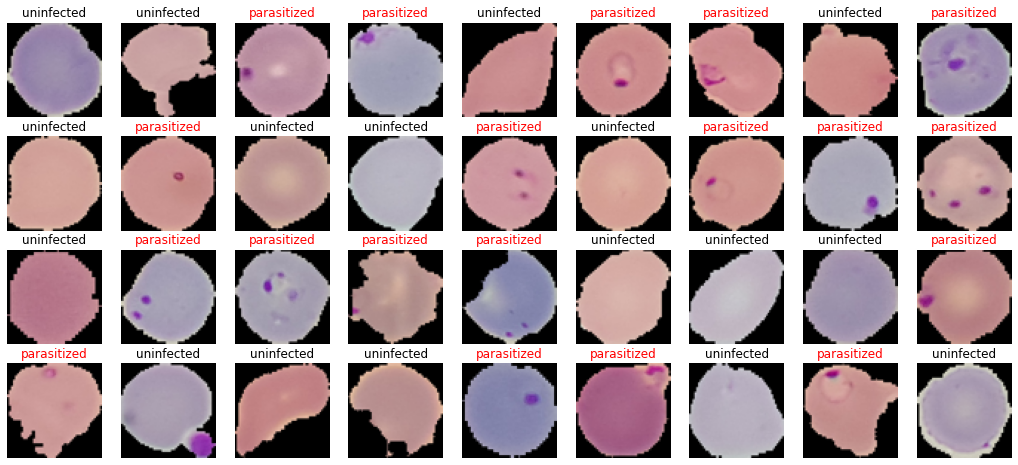

In [ ]:
# Checkups on database
train_images,train_labels,test_images,test_labels=load_database()
plot_randomimages(train_images,train_labels,seed=42)

# shapes
print('train: shapes=',train_images.shape, train_labels.shape)
print('test: shapes=',test_images.shape,test_labels.shape)
# ranges/missing values
print('train: ranges,missing=',train_images.min(),train_images.max(),np.count_nonzero(np.isnan(train_images)))
print('train: ranges,missing=',test_images.min(),test_images.max(),np.count_nonzero(np.isnan(test_images)))
# label counts
for ilabel,iname in zip([train_labels,test_labels],['train','test']):
  a=np.count_nonzero(ilabel==0)
  b=np.count_nonzero(ilabel==1)
  c=a+b
  print(iname+': counts of label 0,1=',a,',',b,' (',round(a/c*100),'%,',round(b/c*100),'%)')



###<b> Comments</b>

- Database consists of 24,958 train and 2,600 test samples. The samples are microscopic images (colored) of invidual red cells, isolated from a (thin) blood smear and framed/cropped perfectly. Label is either parasitized (=1) or uninfected (=0), balanced perfectly in train and test.
- Uninfected cells are rather ellipsoidal and uniform, with color ranging from light pink to light blue. They sometimes show a lighter center. Parasitized cells are similar but contain one or several smaller bodies of the malaria parasite. Both type of cells can look disformed as an artifact of the experimental method (framing and cropping). 
- The goal is to train a Convolutional Neural Network to predict label  from image. 



#<b> Part II: Problem Solution</b>

##<b>Data Augmentation</b>

(-0.5, 63.5, 63.5, -0.5)

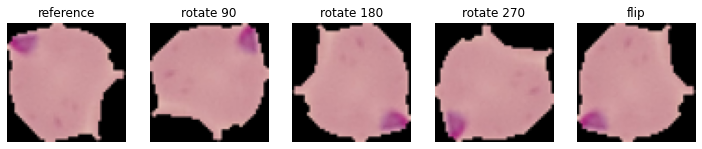

In [ ]:
# Show all possible transformations for a sample image
index=1689
ref_image, ref_label=train_images[index], train_labels[index]
nx=8
plt.figure(None , figsize = (20 , 4))
plt.subplot(1, nx, 1)
plt.imshow(ref_image)
plt.title('reference')
plt.axis('off')
plt.subplot(1, nx, 2)
plt.imshow(cv2.rotate(ref_image.copy(), cv2.cv2.ROTATE_90_CLOCKWISE))
plt.title('rotate 90')
plt.axis('off')
plt.subplot(1, nx, 3)
plt.imshow(cv2.rotate(ref_image.copy(), cv2.cv2.ROTATE_180))
plt.title('rotate 180')
plt.axis('off')
plt.subplot(1, nx, 4)
plt.imshow(cv2.rotate(ref_image.copy(), cv2.cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.title('rotate 270')
plt.axis('off')
plt.subplot(1, nx, 5)
plt.imshow(cv2.flip(ref_image.copy(), 0))
plt.title('flip')
plt.axis('off')

In [ ]:
# create augmented database
# we augment 1 image to 8 images from 4 rotation angles (0,90,180,270) x 2 flips (flipped/unflipped)
train_images_extended=[]
train_labels_extended=[]
for i,j in zip(train_images,train_labels):
  #
  a1=i.copy()# original
  a2= cv2.rotate(i.copy(), cv2.cv2.ROTATE_90_CLOCKWISE)
  a3= cv2.rotate(i.copy(), cv2.cv2.ROTATE_180)
  a4= cv2.rotate(i.copy(), cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
  #
  a1f=i.copy()# 
  a2f= cv2.rotate(i.copy(), cv2.cv2.ROTATE_90_CLOCKWISE)
  a3f= cv2.rotate(i.copy(), cv2.cv2.ROTATE_180)
  a4f= cv2.rotate(i.copy(), cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
  a1f=cv2.flip(a1f,0)# horizontal or vertical flip is redundant here
  a2f=cv2.flip(a2f,0)
  a3f=cv2.flip(a3f,0)
  a4f=cv2.flip(a4f,0)
  #
  train_images_extended.append(a1)
  train_images_extended.append(a2)
  train_images_extended.append(a3)
  train_images_extended.append(a4)
  train_images_extended.append(a1f)
  train_images_extended.append(a2f)
  train_images_extended.append(a3f)
  train_images_extended.append(a4f)
  for k in range(8):
    train_labels_extended.append(j)

# convert to np.array (prefer np.asarray to np.array whith high risk of RAM crash due to object copy)
train_images_extended=np.asarray(train_images_extended)
train_labels_extended=np.asarray(train_labels_extended)

##<b>Model Architecture</b>

In [ ]:
def buildCNN():
  # Model CNN5 buildup
  inp = Input(shape = (64 , 64 , 3))
  x = Conv2D(filters = 16 , kernel_size = (3,3) , strides = (1,1) , padding = "same" , kernel_initializer=glorot_uniform(seed = 2))(inp)
  x = Activation("relu")(x)
  x = Dropout(0.2)(x)
  x = Conv2D(filters = 32 , kernel_size = (4,4) , strides = (2,2) , padding = "same" , kernel_initializer=glorot_uniform(seed = 2))(x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size = (2,2) , strides = (2,2) , padding = "same")(x)
  x = Dropout(0.2)(x)
  x = Conv2D(filters = 64 , kernel_size = (3,3) , strides = (2,2) , padding = "same" , kernel_initializer = glorot_uniform(seed = 2))(x)
  x = Activation("relu")(x)
  x = Dropout(0.2)(x)
  x = Conv2D(filters = 128 , kernel_size = (3,3) , strides = (1,1) , padding = "same" , kernel_initializer = glorot_uniform())(x)
  x = Activation("relu")(x)
  x = MaxPooling2D(pool_size = (2,2) , strides = (2,2) , padding = "same")(x)
  x = Dropout(0.2)(x)
  x = Conv2D(filters = 256 , kernel_size = (2,2) , strides = (2,2) , padding = "same" , kernel_initializer = glorot_uniform())(x)
  x = Activation("relu")(x)
  x = AveragePooling2D(pool_size = (3,3) , strides = (1,1) , padding = "same")(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(128)(x)
  x = Activation("relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(64)(x)
  x = Activation("relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(32)(x)
  x = Activation("relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(2)(x)
  output = Activation("softmax")(x)
  model  = Model(inputs =inp , outputs = output )
  return model

# compile model
def compileCNN(model):
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  callbacks = [EarlyStopping(monitor='val_loss', patience=2),
              ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0     

None

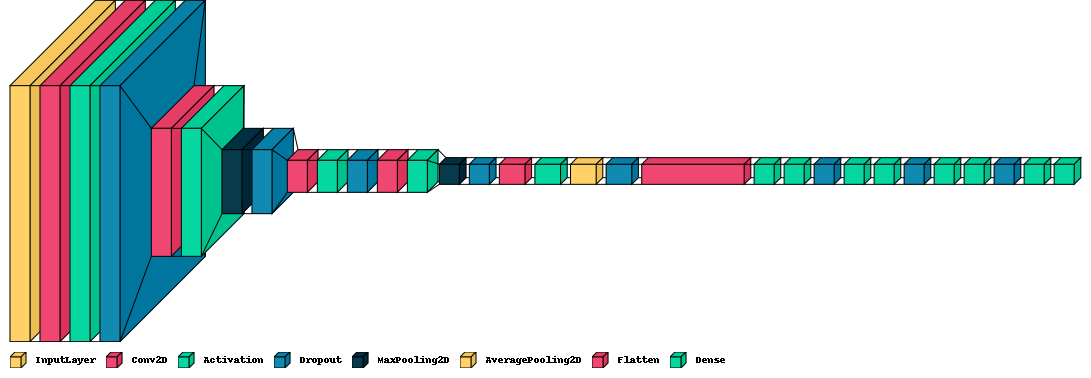

In [ ]:
# Build the CNN 
model5=buildCNN()
# Visualize architecture
display(model5.summary())
visualkeras.layered_view(model5,legend=True)

##<b>Model Training</b>

In [ ]:
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

In [ ]:
#Fit the model
history5=model5.fit(train_images_extended,train_labels_extended,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)



Epoch 1/20
4992/4992 [==============================] - 58s 8ms/step - loss: 0.1787 - accuracy: 0.9386 - val_loss: 0.0897 - val_accuracy: 0.9675
Epoch 2/20
4992/4992 [==============================] - 39s 8ms/step - loss: 0.1373 - accuracy: 0.9555 - val_loss: 0.1176 - val_accuracy: 0.9667
Epoch 3/20
4992/4992 [==============================] - 39s 8ms/step - loss: 0.1304 - accuracy: 0.9573 - val_loss: 0.1154 - val_accuracy: 0.9664


In [ ]:
# save the model
model5.save('/content/drive/MyDrive/Data/CNNFinalSubmission.h5')


None

82/82 [==============================] - 0s 4ms/step - loss: 0.1311 - accuracy: 0.9581

 Test_Accuracy:- 0.9580768942832947
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1300
           1       0.97      0.95      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



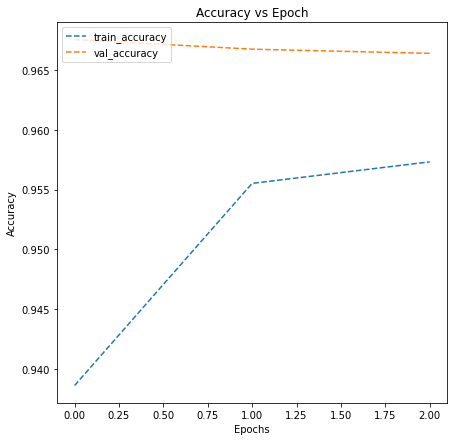

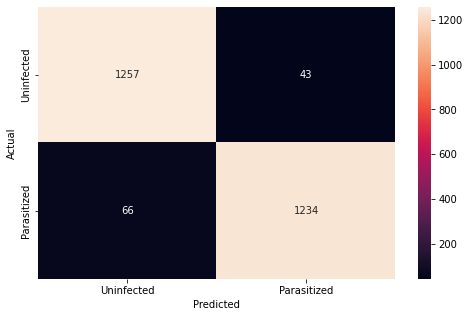

In [ ]:
# checkup performances
display(plot_accuracy(history5))
accuracy = model5.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])
prediction_report(model5,test_images)

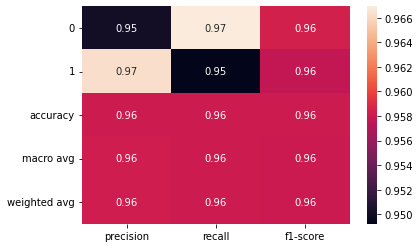

In [ ]:
pred = model5.predict(test_images)
pred = np.argmax(pred,axis = -1) 
y_true = np.argmax(test_labels,axis = -1)
clf_report=classification_report(y_true,pred,output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

##<b>Misclassified Images</b>

There are  109  misclassified images


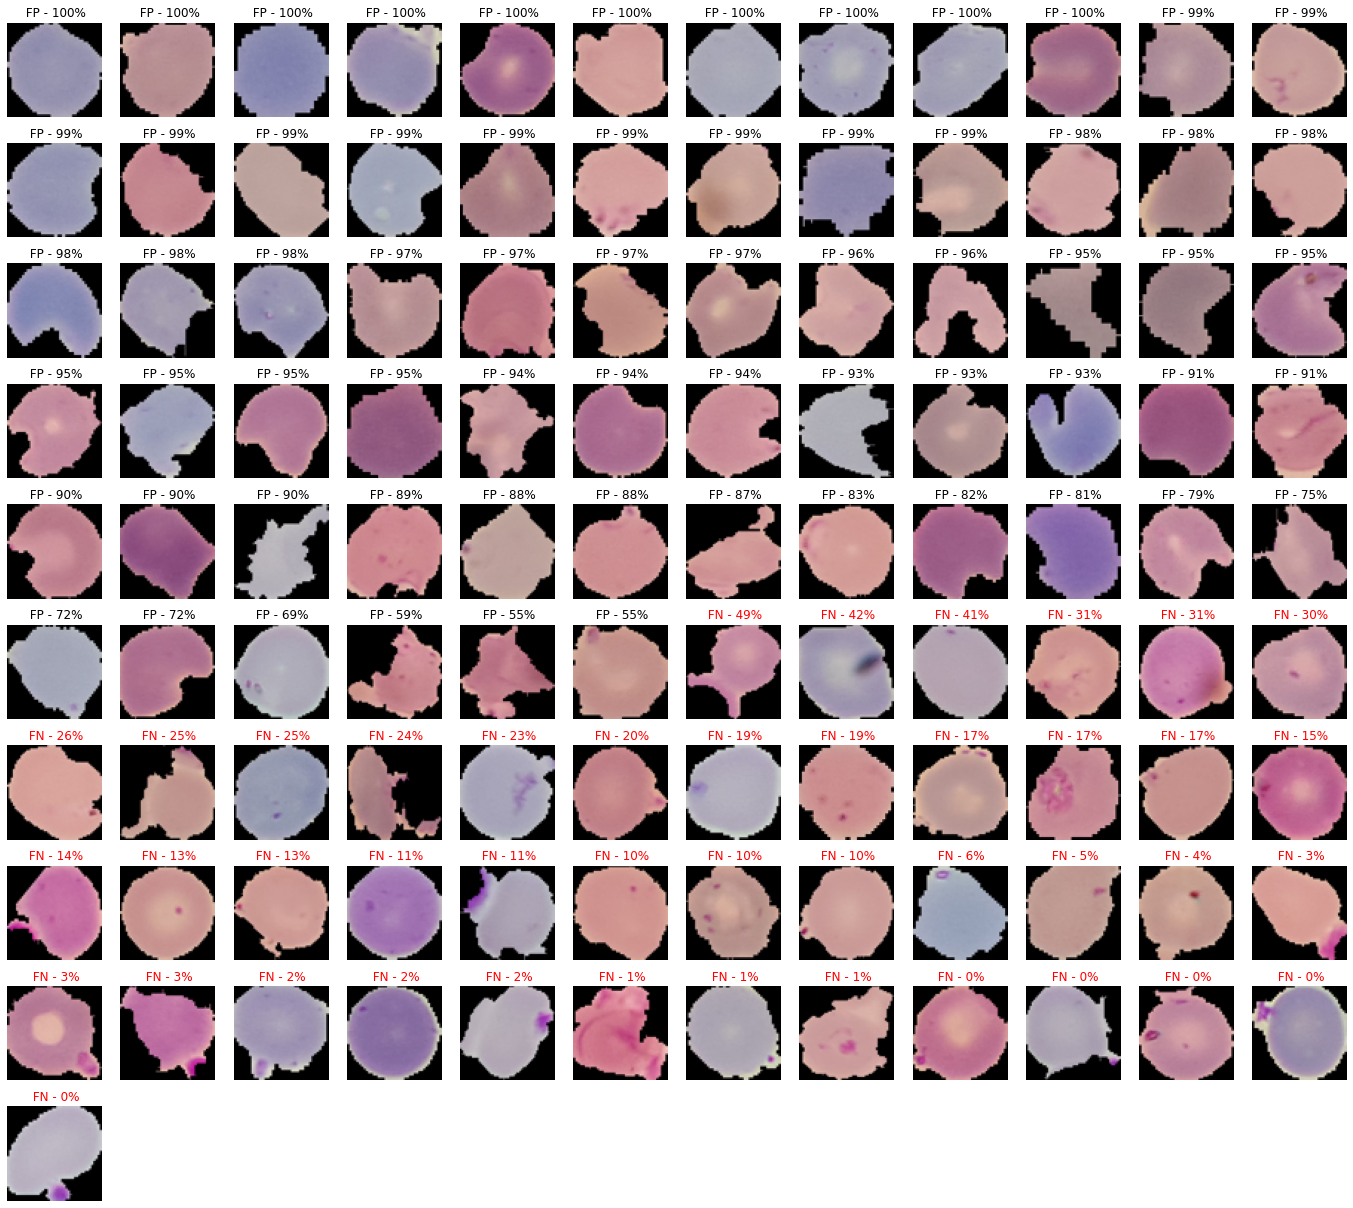

In [ ]:
# Analyze the database of misclassified test images

#model5 = load_model('/content/drive/MyDrive/Data/CNNFinalSubmission.h5')
y_pred_proba = model5.predict(test_images)# predicted probability (two classes)
y_pred = np.argmax(y_pred_proba,axis = -1)# convert boolean
y_true = np.argmax(test_labels,axis = -1)

# Build database of misclassified images
misclass_images=[]
misclass_labels=[]
misclass_probas=[]# predicted probability 0-1
misclass_index=[]# save index from full database
for count,(i,j,k,l) in enumerate(zip(test_images,y_pred,y_true,y_pred_proba)):
  if j != k:
    misclass_images.append(i)# image
    misclass_labels.append(k)# truth
    misclass_probas.append(l[0])# predicted probability
    misclass_index.append(count)# save index from database

# Sort by increasing probability (one liner!)
misclass_probas,misclass_labels,misclass_images = map(list, zip(*sorted(zip(misclass_probas,misclass_labels,misclass_images), reverse=True)))



# Visualize all the misclassified images
print('There are ',len(misclass_probas),' misclassified images')
np.random.seed()
plt.figure(1 , figsize = (24 , 24))

niter=min(len(misclass_probas),11*12)
for n in range(niter):
    plt.subplot(11, 12, n+1)
    index=n# just follow
    # index = int(np.random.randint(0, len(misclass_probas), 1))# any
    # index = int(np.random.randint(0, len(misclass_probas)/4, 1))# first quartile
    # index = int(np.random.randint(3*len(misclass_probas)/4, len(misclass_probas), 1))# last quartile
    plt.imshow(misclass_images[index])
    if misclass_labels[index] == 1:# uninfected
      # plt.title(str(misclass_index[index])+' - '+str(round(misclass_probas[index]*100))+'%')
      plt.title(' FP - '+str(round(misclass_probas[index]*100))+'%')
    else:
      plt.title(str(misclass_index[index])+' - '+str(round(misclass_probas[index]*100))+'%',color='r')
      plt.title(' FN - '+str(round(misclass_probas[index]*100))+'%',color='r')

    plt.axis('off')




##<b> Comments</b>
- We have augmented the starting dataset using natural" transformations that could randomly occur in the experimental setup. Each image has been duplicated 8 times using transformations from 4 rotations angles (0,90,180,270 deg) x 2 flip states (flipped/unflipped). This allows for better training of the CNN.  
- The CNN consists of 5 convolution layers (along with 2 max pool and one average pool layers) and 3 fully-connected layers. This is a very deep CNN with relatively few trainable parameters (~400 000). It trains very fast on the augmented dataset(a few epochs/minutes). 
- The CNN model has around 96% accuracy on the test data. It isnt overfitted as seen by comparison with scores on train/validation datasets.
    
 

#<b> Part III: Recommendations for Implementation</b>

##<b>Error Estimation for Cell Count</b>

Is the computer vision accuracy (96%) acceptable to use the protocol in practice? We determine this using a statistical analysis. 

Let the practical protocol for malaria diagnosis analyze $N$ individual red cells from a patient, of which a fraction $r$ is infected. Each cell is analyzed with the computer vision model (CNN) with error $e$=0.04 (i.e. 96% accuracy). We can formulate this as an independent test with Bernouilli distribution of probability $p$ that the cell is predicted as parasitized. It follows that\:
$$p= r(1-e)+(1-r)e$$ 

i.e. the model may predict a cell as parasitized correctly or from misclassification. Importantly, if the computer vision model was perfect ($e=0$) we would obtain $p=r$. 

Let $C$ be the count of parasitized cells (used to diagnose malaria intensity). $C$ follows a Binomial distribution with probability mass function given by\:
$$f(k)={{N!}\over{k!(N-k)!}} p^k(1-p)^{N-k}$$
that depends on problem parameters $N$, $e$ and $r$. In particular, we want to compare the distributions from our model ($e=0.04$) with a perfect model ($e=0$) for varying  $N$ and $r$. 

Note: in our previous report (Milestone 2), we had performed a similar analysis but with a fixed (instead of probabilistic) fraction of infected cells $r$. Letting $r$ be a random variable makes more sense because 1.) the $N$ samples are chosen randomly from a patients blood and because 2.) it simplifies the analysis.



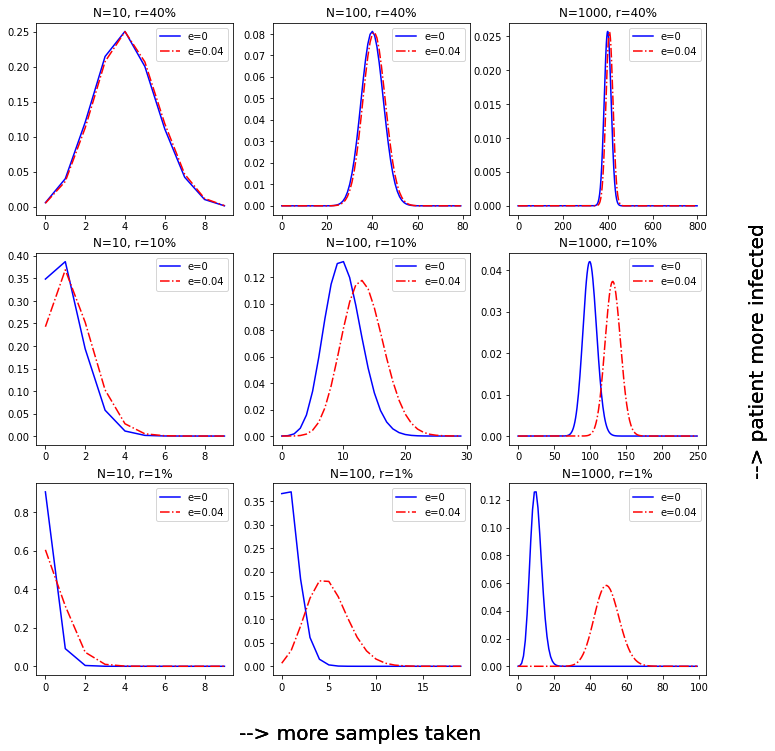

In [ ]:
# Plot bernouilli
N=100# number of samples
e=0.04# error
r=0.1# fraction of infected cells

def make_binomial(N,e,r):
  p=r*(1-e)+(1-r)*e
  pmf0=scipy.stats.binom.pmf(range(N),N,r)
  pmf=scipy.stats.binom.pmf(range(N),N,p)
  # crop 
  return pmf0,pmf

Nvect=[10,100,1000]
rvect=[0.4,0.1,0.01]
cutsvect2=[[1,0.8,0.8],[1,0.3,0.25],[1,0.2,0.1]]# cutoff uperbound
fig,ax=plt.subplots(nrows=3,ncols=3,figsize = (12 , 12))
for iplot in range(3):
  for jplot in range(3):
    nplot=iplot*3+jplot
    plt.subplot(3, 3, nplot+1)
    N=Nvect[jplot]
    r=rvect[iplot]
    cut2=cutsvect2[iplot][jplot]
    pmf0,pmf=make_binomial(N,e,r)
    pmf0=pmf0[0:int(N*cut2)]
    pmf=pmf[0:int(N*cut2)]
    plt.plot(pmf0,'b-',label='e=0')
    plt.plot(pmf,'r-.',label='e=0.04')
    plt.title('N='+str(N)+', r='+str(round(r*100))+'%')
    # plt.xlim=(0,10)
    plt.xlim=(0,10)
    plt.legend()
  #
  fig.text(0.5, 0.05, '--> more samples taken', ha='center',fontsize=20)
  fig.text(0.95, 0.5, '--> patient more infected', va='center',rotation='vertical',fontsize=20)
  
    


##<b>Comments</b>


- In a practical protocol for malaria diagnosis, a blood smear is taken from a patient from containing several (hundreds to thousands) red cells. Each cell is classified individually by the computer vision model (CNN) with 96% accuracy The count of parasitized cells allows to diagnose the presence and intensity of the malaria. 
- The count of parasitized cells is prone to errors that depend on the computer vision model accuracy (96%), the number of samples taken and the patient's level of infection. Around 100-1000 samples should be taken to ensure statistical confidence.The protocol fails to diagnose patients with early infection (1% parasitized cells), but is good to diagnose more advanced levels above 10%. It might be possible to calibrate the protocol to correct these biases.   
